<a href="https://colab.research.google.com/github/Ethan-code-1/DS_4002_Project2/blob/main/final_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Load necessary libraries. install what you don't have
import numpy as np
import pandas as pd
import requests
import urllib
import os
import pprint
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.stats import f

In [2]:
df = pd.read_excel("/content/original_data.xls", sheet_name="Data")

In [3]:
#Columns from original dataset we want to keep
columns_to_keep = ["Date", "S&P Comp. P", "Earnings", "Real Total Return Price" ]
df = df[columns_to_keep]

#Date format is inconsistent so lets make the formatting better and recognized as a date data type
#df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y-%m-%d")
df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y.%m")


#Filter out all dates before 1965, reconsider if this is a good selection later
df = df[df["Date"] >= "1965-01-01"]

df = df.sort_values("Date").reset_index(drop=True)

#Added PE ratio column
df["PE Ratio"] = df["S&P Comp. P"] / df["Earnings"]

#Drop price and earnings columns because that data is now stored in the PE column
df = df.drop(columns=["S&P Comp. P", "Earnings"])

#df.rename(columns={"10 Year Annualized Stock Real Return": "10 Year Return"}, inplace=True)


print(df.head())

        Date  Real Total Return Price   PE Ratio
0 1965-01-01            109618.976259  18.748925
1 1965-01-01            117075.340722   18.09703
2 1965-02-01            110689.595261  18.709548
3 1965-03-01            110707.980510  18.553419
4 1965-04-01            112076.467028  18.585224


<ipython-input-3-d71fe4368d8d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y.%m")


In [4]:
# General function to calculate N-year returns
#Takes in 3 paramaters, a date, the dataframe, and then how many years out you want to calculate annual returns for
def get_n_year_return(date, df, years):
    #Calculates a target date by adding desired amount of years to current date to get futrue date (defaults to 10)
    target_date = date + pd.DateOffset(years=years)
    #Filters dataframe to only include dates that occur after the date provided to make searching quicker, then looks for the target date n years out

    # Filter the DataFrame to only include dates on or after the target date
    future_rows = df[df["Date"] >= target_date]

    # Check if there are any rows left after filtering
    if not future_rows.empty:
        # Select the first row (earliest available future date)
        future_row = future_rows.iloc[0]
    else:
        # If no future row is found, return None
        future_row = None


    if future_row is not None:
        #If some observation n years out exists, then using the compound annual growth formula given by original dataset calcualte the CAGR annual return
        return (future_row["Real Total Return Price"] / df[df["Date"] == date]["Real Total Return Price"].values[0]) ** (1/years) - 1
    return None  # Return None if no valid future date is found

# Create an empty list to store results
three_year_returns = []


# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    three_year_returns.append(get_n_year_return(row["Date"], df, 3))

# Assign results to new columns
df["3 Year Annual Return"] = three_year_returns

# Display the first few rows
print(df.head())

        Date  Real Total Return Price   PE Ratio  3 Year Annual Return
0 1965-01-01            109618.976259  18.748925              0.062185
1 1965-01-01            117075.340722   18.09703              0.062185
2 1965-02-01            110689.595261  18.709548              0.016211
3 1965-03-01            110707.980510  18.553419              0.009866
4 1965-04-01            112076.467028  18.585224              0.029799


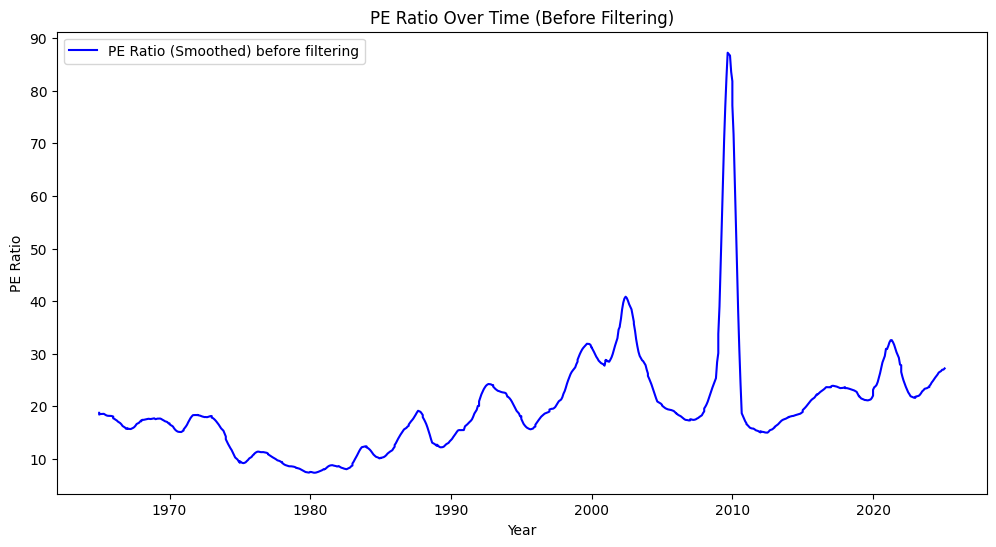

In [5]:
# Plot PE Ratio over time before filtering
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["PE Ratio"].rolling(window=12, min_periods=1).mean(),
         label="PE Ratio (Smoothed) before filtering", color='blue')
plt.xlabel("Year")
plt.ylabel("PE Ratio")
plt.title("PE Ratio Over Time (Before Filtering)")
plt.legend()
plt.show()


In [6]:
# Compute the 5th and 95th percentiles
low_cutoff = df["PE Ratio"].quantile(0.05)
high_cutoff = df["PE Ratio"].quantile(0.95)

# Filter out outliers
df_filtered = df[(df["PE Ratio"] >= low_cutoff) & (df["PE Ratio"] <= high_cutoff)]


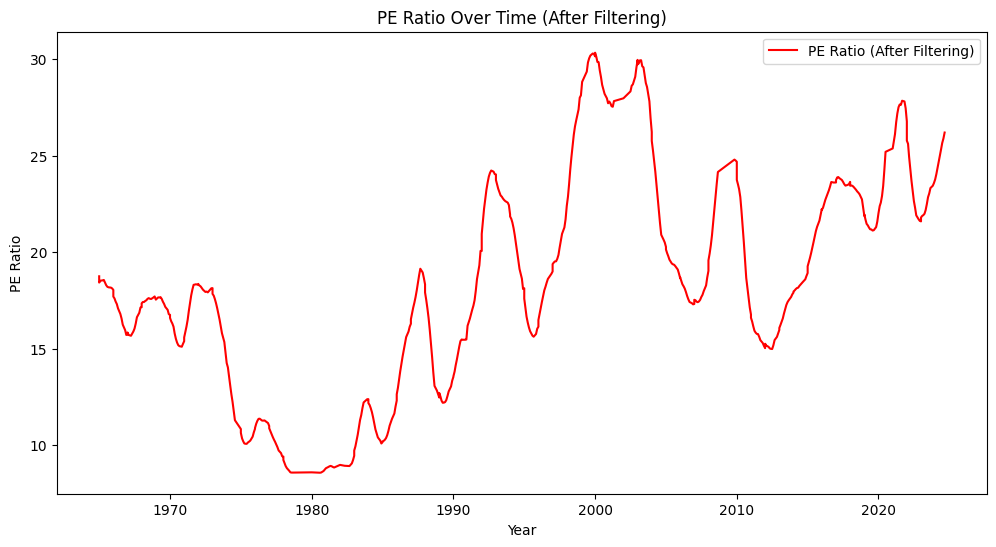

In [7]:
# Plot PE Ratio over time after filtering
plt.figure(figsize=(12,6))
plt.plot(df_filtered["Date"], df_filtered["PE Ratio"].rolling(window=12, min_periods=1).mean(), label="PE Ratio (After Filtering)", color='red')
plt.xlabel("Year")
plt.ylabel("PE Ratio")
plt.title("PE Ratio Over Time (After Filtering)")
plt.legend()
plt.show()

<ipython-input-8-32117322f5dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df['Date'])


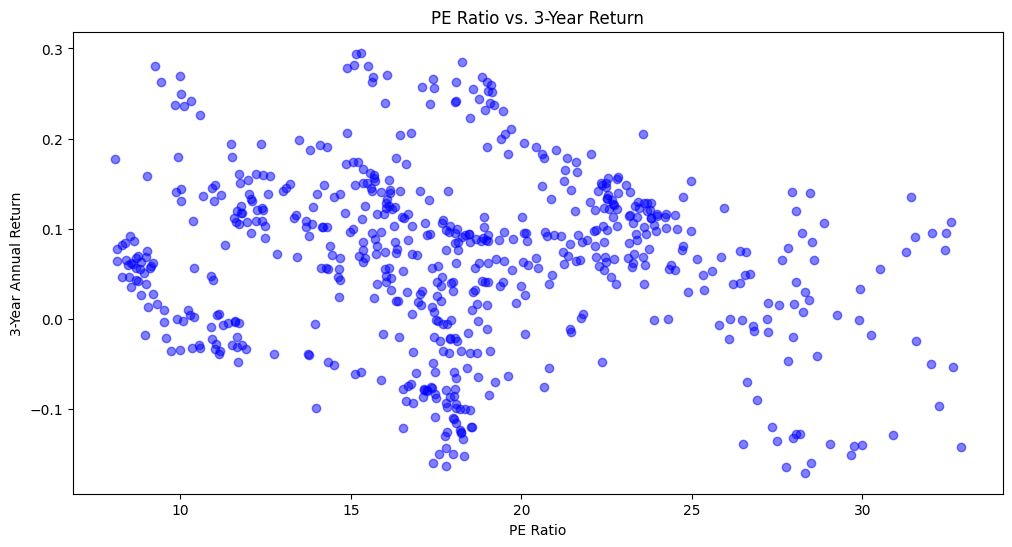

In [8]:
# Convert Date to datetime format
df_filtered['Date'] = pd.to_datetime(df['Date'])

# Set Date as the index for time series data
df_filtered.set_index('Date', inplace=True)

# Plot PE Ratio vs 3-Year Return to visually inspect the relationship
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered['PE Ratio'], df_filtered['3 Year Annual Return'], color='blue', alpha=0.5)
plt.title("PE Ratio vs. 3-Year Return")
plt.xlabel("PE Ratio")
plt.ylabel("3-Year Annual Return")
plt.show()

plt.show()

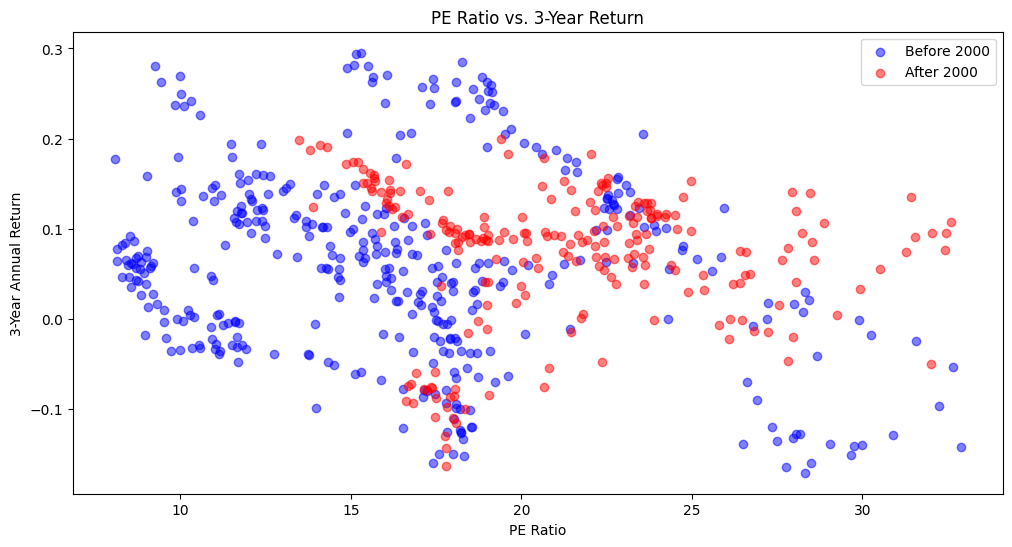

In [9]:
# Create a boolean mask for dates after 2005
after_2000 = df_filtered.index.year > 2000

# Separate data points based on the mask
pe_before_2000 = df_filtered.loc[~after_2000, 'PE Ratio']
return_before_2000 = df_filtered.loc[~after_2000, '3 Year Annual Return']
pe_after_2000 = df_filtered.loc[after_2000, 'PE Ratio']
return_after_2000 = df_filtered.loc[after_2000, '3 Year Annual Return']

# Plot the scatter plot with different colors
plt.figure(figsize=(12, 6))
plt.scatter(pe_before_2000, return_before_2000, color='blue', alpha=0.5, label='Before 2000')
plt.scatter(pe_after_2000, return_after_2000, color='red', alpha=0.5, label='After 2000')

plt.title("PE Ratio vs. 3-Year Return")
plt.xlabel("PE Ratio")
plt.ylabel("3-Year Annual Return")
plt.legend()  # Add a legend to distinguish the colors
plt.show()

<ipython-input-10-4cb980bfa8eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["3 Year Annual Return"] = df_filtered["3 Year Annual Return"].fillna(df_filtered["3 Year Annual Return"].mean())
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


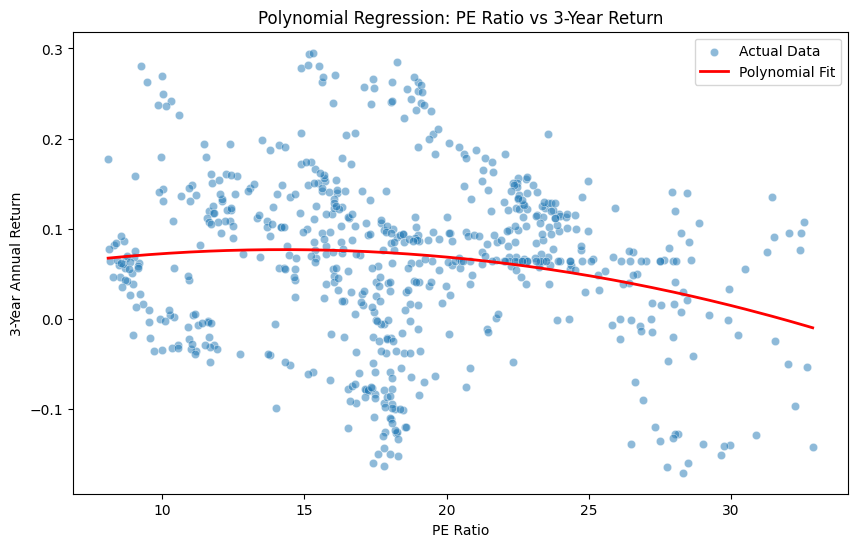

R² Score: 0.0323


In [10]:
# Fill missing values
df_filtered["3 Year Annual Return"] = df_filtered["3 Year Annual Return"].fillna(df_filtered["3 Year Annual Return"].mean())

# Generate polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df_filtered[["PE Ratio"]])

# Fit model
model_poly = LinearRegression().fit(X_poly, df_filtered["3 Year Annual Return"])

# Generate smooth curve by sorting PE values
PE_sorted = np.sort(df_filtered["PE Ratio"])
X_poly_sorted = poly.transform(PE_sorted.reshape(-1, 1))
y_pred_sorted = model_poly.predict(X_poly_sorted)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_filtered["PE Ratio"], y=df_filtered["3 Year Annual Return"], alpha=0.5, label="Actual Data")
plt.plot(PE_sorted, y_pred_sorted, color='red', linewidth=2, label="Polynomial Fit")  # Smooth curve
plt.xlabel("PE Ratio")
plt.ylabel("3-Year Annual Return")
plt.legend()
plt.title("Polynomial Regression: PE Ratio vs 3-Year Return")
plt.show()

print(f"R² Score: {r2_score(df_filtered['3 Year Annual Return'], model_poly.predict(X_poly)):.4f}")


In [11]:
#grainger causality tests

from statsmodels.tsa.stattools import grangercausalitytests

df = df_filtered[["PE Ratio", "3 Year Annual Return"]].dropna()
max_lag = 5
test_results = grangercausalitytests(df, max_lag, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6225  , p=0.4304  , df_denom=641, df_num=1
ssr based chi2 test:   chi2=0.6254  , p=0.4291  , df=1
likelihood ratio test: chi2=0.6251  , p=0.4292  , df=1
parameter F test:         F=0.6225  , p=0.4304  , df_denom=641, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5131  , p=0.5989  , df_denom=638, df_num=2
ssr based chi2 test:   chi2=1.0343  , p=0.5962  , df=2
likelihood ratio test: chi2=1.0335  , p=0.5965  , df=2
parameter F test:         F=0.5131  , p=0.5989  , df_denom=638, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6785  , p=0.5654  , df_denom=635, df_num=3
ssr based chi2 test:   chi2=2.0579  , p=0.5605  , df=3
likelihood ratio test: chi2=2.0546  , p=0.5612  , df=3
parameter F test:         F=0.6785  , p=0.5654  , df_denom=635, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5812  , p=0.6764  

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


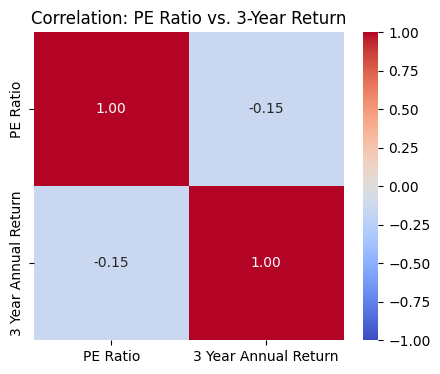

In [12]:
# Compute correlation matrix
corr_matrix = df_filtered[["PE Ratio", "3 Year Annual Return"]].corr()

# Plot heatmap
plt.figure(figsize=(5, 4))  # Adjust figure size for clarity
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add title
plt.title("Correlation: PE Ratio vs. 3-Year Return")

# Show plot
plt.show()

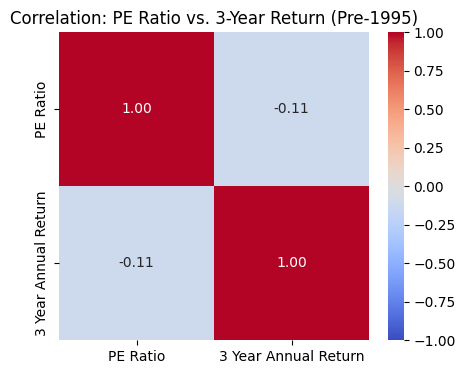

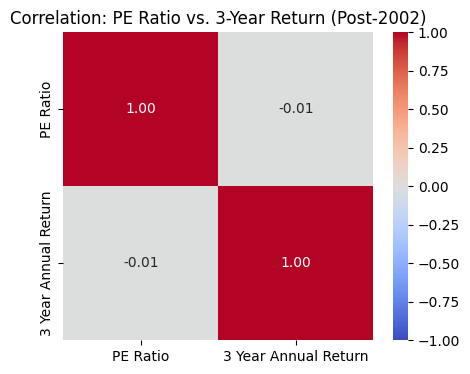

In [13]:
df_filtered = df_filtered.reset_index()
# Filter data for observations after 2000
df_filtered_2000 = df_filtered[df_filtered["Date"] <= "1995-01-01"]

# Compute correlation matrix for PE Ratio and 3-Year Annual Return
corr_matrix = df_filtered_2000[["PE Ratio", "3 Year Annual Return"]].corr()

# Plot heatmap
plt.figure(figsize=(5, 4))  # Adjust figure size for clarity
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add title
plt.title("Correlation: PE Ratio vs. 3-Year Return (Pre-1995)")

# Show plot
plt.show()



# Filter data for observations after 2000
df_filtered_2000 = df_filtered[df_filtered["Date"] >= "2002-01-01"]

# Compute correlation matrix for PE Ratio and 3-Year Annual Return
corr_matrix = df_filtered_2000[["PE Ratio", "3 Year Annual Return"]].corr()

# Plot heatmap
plt.figure(figsize=(5, 4))  # Adjust figure size for clarity
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add title
plt.title("Correlation: PE Ratio vs. 3-Year Return (Post-2002)")

# Show plot
plt.show()


In [14]:
df_filtered["PE Ratio"] = pd.to_numeric(df_filtered["PE Ratio"], errors="coerce")
print(df_filtered.dtypes)

Date                       datetime64[ns]
Real Total Return Price           float64
PE Ratio                          float64
3 Year Annual Return              float64
dtype: object


In [16]:
!pip install ruptures

import ruptures as rpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00


In [17]:
#Find breakpoints. These may or may not align with crises and may instead be showing the breaks before actual crises start taking place
signal = df_filtered[["PE Ratio", "3 Year Annual Return"]].dropna().values

model = rpt.Dynp(model="l2").fit(signal)
signal = df_filtered[["PE Ratio", "3 Year Annual Return"]].dropna().values

#Increasing the number of breakpoints increases the number of ways that people can find out potential places for changes in trends.
model = rpt.Dynp(model="l2").fit(signal)
breakpoints = model.predict(n_bkps=5)

break_years = [df_filtered.iloc[bp]["Date"].year for bp in breakpoints[:-1]]
print(break_years)


[1973, 1985, 1997, 2004, 2015]


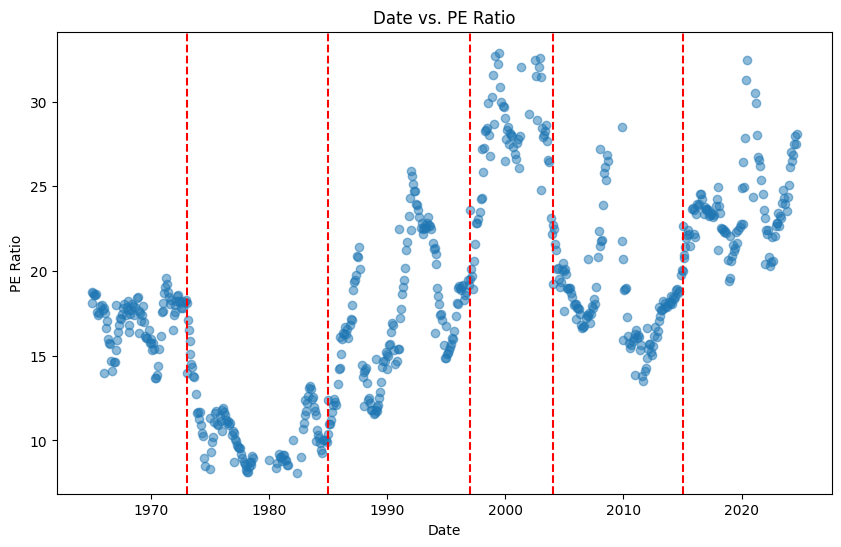

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["Date"], df_filtered["PE Ratio"], alpha=0.5)
plt.title("Date vs. PE Ratio")
plt.xlabel("Date")
plt.ylabel("PE Ratio")
for year in break_years:
    plt.axvline(pd.Timestamp(f"{year}-01-01"), color='red', linestyle='--')
plt.show()

In [19]:
#Check directly for significance via F tests

from statsmodels.formula.api import ols

break_dates = df_filtered.iloc[breakpoints[:-1]].index
df_filtered["Breakpoint"] = 0
df_filtered.loc[break_dates, "Breakpoint"] = 1

model = ols("Q('3 Year Annual Return') ~ Q('PE Ratio') + Breakpoint", data=df_filtered).fit()
print(model.summary())

constraint = np.array([0,0,1])
f_test = model.f_test(constraint)
print(f_test)

                                OLS Regression Results                               
Dep. Variable:     Q('3 Year Annual Return')   R-squared:                       0.022
Model:                                   OLS   Adj. R-squared:                  0.019
Method:                        Least Squares   F-statistic:                     7.200
Date:                       Sun, 23 Mar 2025   Prob (F-statistic):           0.000809
Time:                               22:15:37   Log-Likelihood:                 622.69
No. Observations:                        645   AIC:                            -1239.
Df Residuals:                            642   BIC:                            -1226.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------